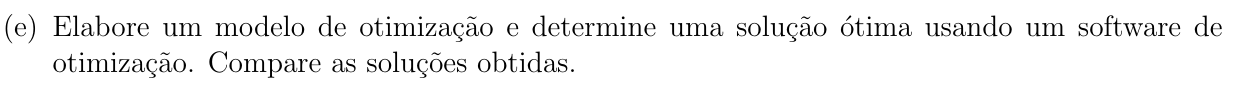

In [3]:
from IPython.display import Image
Image(filename='images/2e.png')

In [95]:
# Bibliotecas
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import xlwings as xw
import pandas as pd

In [96]:
# Conexão com a planilha
wb = xw.Book('dados_1.xlsx')
sheet = wb.sheets['Plan3']

In [97]:
# Conjuntos
Clientes = sheet.range('D2:H2').value; n = len(Clientes)  # Número de clientes
Nos = sheet.range('C2:I2').value

In [98]:
# Parâmetros:
distancias = sheet.range('B2:I9').options(pd.DataFrame).value.stack().to_dict()
n_caminhoes = sheet.range('B11').value
capacidade = sheet.range('B12').value
velocidade = sheet.range('B13').value
demanda = sheet.range('D12:E18').options(dict).value
tempo_inicial = sheet.range('A21:B27').options(dict).value
tempo_final = sheet.range('D21:E27').options(dict).value
tempo_servico = sheet.range('G21:H27').options(dict).value

In [99]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.C = Set(initialize=Clientes)
model.N = Set(initialize=Nos)
C, N = model.C, model.N

# Parâmetros
model.D = Param(N * N, initialize=distancias, within=NonNegativeReals)
model.c = Param(initialize=n_caminhoes, within=NonNegativeReals)
model.Q = Param(initialize=capacidade, within=NonNegativeReals)
model.v = Param(initialize=velocidade, within=NonNegativeReals)
model.a = Param(N, initialize=demanda, within=NonNegativeReals)
model.I = Param(N, initialize=tempo_inicial, within=NonNegativeReals)
model.F = Param(N, initialize=tempo_final, within=NonNegativeReals)
model.S = Param(N, initialize=tempo_servico, within=NonNegativeReals)
D, c, Q, v, a, I, F, S = (model.D, model.c, model.Q, model.v, model.a,
                          model.I, model.F, model.S)

# Variáveis de decisão
model.x = Var(N * N, within=Binary)
model.u = Var(N, within=NonNegativeReals)
model.w = Var(N, within=NonNegativeReals)
x, u, w = model.x, model.u, model.w

# Função objetivo
model.obj = Objective(expr=sum(sum(D[i, j] * x[i, j] for j in N) for i in N))

# Restrições
# 1. Cada cliente visitado uma vez
model.r_visita = ConstraintList()
for i in C:
    model.r_visita.add(expr=sum(x[i, j] for j in N if (j > 0 and j != i)) == 1)
    
# 2. Mesmo veículo visita antecessor/sucessor
model.r_sucessor = ConstraintList()
for h in C:
    model.r_sucessor.add(expr=sum(x[i, h] for i in N if (i < n + 1 and i != h)) == sum(x[h, j] for j in N if (j > 0 and j != h)))
    
# 3. Veículo deve sair do depósito
model.r_saida = ConstraintList()
model.r_saida.add(expr=sum(x[0, j] for j in N if j > 0) <= 10**5)

# 4. Veículo deve voltar ao depósito
model.r_volta = ConstraintList()
model.r_volta.add(expr=sum(x[i, n + 1] for i in N if (i < n + 1)) <= 10**5)

# 5. Consistência das rotas
model.r_fluxo = ConstraintList()
model.r_fluxo.add(expr=sum(x[0, j] for j in N if j > 0) == sum(x[i, n + 1] for i in N if (i < n + 1)))

# 6. Restrição MTZ
model.r_MTZ = ConstraintList()
model.r_MTZ.add(expr=u[0] == 0)
for i in N:
    model.r_MTZ.add(expr=u[i] <= Q)
    if i != (n + 1):
        for j in C:
            if i != j:
                model.r_MTZ.add(expr=u[j] >= u[i] + a[j] * x[i, j] + Q * (x[i, j] - 1))

# 7. Restrições de tempo
model.r_tempo = ConstraintList()
model.r_tempo.add(expr=w[0] == 0)
for i in N:
    model.r_tempo.add(expr=w[i] <= F[i])
    model.r_tempo.add(expr=w[i] >= I[i])
    if i != (n + 1):
        for j in N:
            if j != 0:
                model.r_tempo.add(expr=w[j] >= w[i] + (S[i] + D[i, j] / v) * x[i, j] + 10000 * (x[i, j] - 1)) 

In [100]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [101]:
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    print(f'Distancia mínima: {value(model.obj)} km')
    print()
    for i in N:
        if i < n + 1:
            for j in N:
                if j > 0:
                    if (i != j) and (value(x[i, j]) == 1):
                        print(f'O vendedor vai da cidade {int(i)} para {int(j)}')
else:
     print(resultado.solver.termination_condition)

Distancia mínima: 1596.0 km

O vendedor vai da cidade 0 para 2
O vendedor vai da cidade 0 para 3
O vendedor vai da cidade 0 para 5
O vendedor vai da cidade 1 para 6
O vendedor vai da cidade 2 para 4
O vendedor vai da cidade 3 para 6
O vendedor vai da cidade 4 para 6
O vendedor vai da cidade 5 para 1
